<a href="https://colab.research.google.com/github/yishairasowsky/Sefaria-Project/blob/master/ML/topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd

In [0]:
prayer_df = pd.read_csv('/content/prayer-sources.csv', 
                        # encoding="latin-1"
                        )
not_prayer_df = pd.read_csv('/content/not-prayer-sources.csv', 
# not_prayer_df = pd.read_csv('/content/not-prayer-sources-more.csv', 
                            # encoding="latin-1"
                            )

In [517]:
prayer_df.sample(3)

,Ref,En,He
219,Sefer Chasidim 211:1,NaN,אם ראית חסידים שלוקים דע לך שהיה להם לבקש על אחרים שלא ילקו או מתחברים לרשעים או דרים בעיר עמהם ...
97,Daniel 6:11,"And when Daniel knew that the writing was signed, he went into his house—now his windows were op...",וְ֠דָנִיֵּאל כְּדִ֨י יְדַ֜ע דִּֽי־רְשִׁ֤ים כְּתָבָא֙ עַ֣ל לְבַיְתֵ֔הּ וְכַוִּ֨ין פְּתִיחָ֥ן לֵהּ...
459,Bava Batra 123a:6,"The baraita cites additional related verses: And with regard to Jacob’s bequest to Joseph, the v...","ואומר (בראשית מח, כב) ואני נתתי לך שכם אחד על אחיך אשר לקחתי מיד האמורי בחרבי ובקשתי וכי בחרבו ו..."


In [518]:
prayer_df['is_prayer'] = 'yes'
prayer_df = prayer_df[['En','is_prayer']]

prayer_df.tail(3)

,En,is_prayer
1049,"It is true that you are the one who judges, and reproves, who knows all, and bears witness, who ...",yes
1050,"In these Berachot (blessings) we bow down: the first Beracha (blessing) [of Shemoneh Esreh], in ...",yes
1051,On seeds he says [the Beracha (blessing)] Borei Minei Zerayim (Who created different types of se...,yes


In [519]:
not_prayer_df.sample(3)

,Ref,En,He,Topics
323,Ruth 4:14,"And the women said unto Naomi: ‘Blessed be the LORD, who hath not left thee this day without a n...",וַתֹּאמַ֤רְנָה הַנָּשִׁים֙ אֶֽל־נָעֳמִ֔י בָּר֣וּךְ יְהוָ֔ה אֲ֠שֶׁר לֹ֣א הִשְׁבִּ֥ית לָ֛ךְ גֹּאֵ֖...,lot|king-david|moab|ruth|shavuot|naomi|kindness
47,Kiddushin 16a:3,The Gemara asks: This works out well according to the one who says that the master writes the do...,"הניחא למ""ד שטר אמה העבריה אדון כותבו אלא למ""ד אב כותבו מאי איכא למימר דאיתמר שטר אמה העבריה מי כ...",laws-of-hebrew-jewish-maidservants
427,Isaiah 49:11,"And I will make all My mountains a way, And My highways shall be raised on high.",וְשַׂמְתִּ֥י כָל־הָרַ֖י לַדָּ֑רֶךְ וּמְסִלֹּתַ֖י יְרֻמֽוּן׃,emancipation1


In [520]:
not_prayer_df['is_prayer'] = 'no'
not_prayer_df = not_prayer_df[['En','is_prayer']]
not_prayer_df.sample(3)

,En,is_prayer
490,If the robber collected the land that he had sold as payment for a debt owed to him by the robbe...,no
594,""" Then the king consulted the sages learned in procedure (Esther 1:13)"": who were they? Rabbi Si...",no
876,NaN,no


In [521]:
all_prayer_frames = [prayer_df, not_prayer_df]
all_prayer_df = pd.concat(all_prayer_frames)
all_prayer_df.reset_index(inplace=True)
# all_prayer_df.style.set_properties({'align': 'right'})

# all_prayer_df.tail(3)
all_prayer_df.sample(5)
# all_prayer_df.loc[[345]]

,index,En,is_prayer
2070,1018,"And Shemu᾽el spoke to all the house of Yisra᾽el, saying, If you return to the Lord with all your...",no
1801,749,We will not go up. It is possible that the Tent of Meeting was located on high ground within the...,no
1872,820,NaN,no
1781,729,NaN,no
1591,539,NaN,no


In [522]:
print("Before dropping duplicates",all_prayer_df.shape)
all_prayer_df.drop_duplicates(inplace=True)
print("After dropping duplicates",all_prayer_df.shape)
print("Nulls before dropping:",all_prayer_df.isnull().sum()[0])
all_prayer_df.dropna(inplace=True)
print("Nulls after dropping:",all_prayer_df.isnull().sum()[0])
# all_prayer_df.isnull().sum()
# all_prayer_df.sample(5)

Before dropping duplicates (2103, 3)
After dropping duplicates (2103, 3)
Nulls before dropping: 0
Nulls after dropping: 0


In [523]:
del all_prayer_df['index']
all_prayer_df.sample(3)

,En,is_prayer
1326,"The Gemara comments: Granted, according to the one who said that it was an enclosed veranda whic...",no
354,'וה' פקד את שרה וגו AND THE LORD VISITED SARAH —It (Scripture) places this section after the pre...,yes
1662,"And the king commanded Hilkiah the priest, and Ahikam the son of Shaphan, and Achbor the son of ...",no


In [524]:
shape = all_prayer_df.shape
print(f"{shape[0]} rows and {shape[1]} columns")

1247 rows and 2 columns


In [525]:
all_prayer_df['is_prayer'] = all_prayer_df['is_prayer'].map({'no': 0, 'yes': 1})
all_prayer_df.sample(5)

,En,is_prayer
187,"But sanctify yourselves, and be holy in your bodies, that your prayers may be received with acce...",1
1480,§ The mishna teaches: And vinegar belonging to gentiles that was originally wine is prohibited. ...,0
2030,Rav Sheshet said to Rav Naḥman: I also applied the principle of the discretion of the judges and...,0
1291,The baraita continues its determination of how much oil is brought with the griddle-cake offerin...,0
389,"""And Avraham called the name of the place ""Ad-nai Yireh"" [Ad-nai will see] (Gen. 22:14). Rabbi Y...",1


In [526]:
print('Prayer:', (all_prayer_df.is_prayer.values == 1).sum())
print('Not prayer:', (all_prayer_df.is_prayer.values == 0).sum())

Prayer: 579
Not prayer: 668


In [527]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_ \b\d+\b]')
STOPWORDS = set(stopwords.words('english'))

def process_text(text):
    #  text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# whitelist = set('abcdefghijklmnopqrstuvwxyz ZXCVBNMASDFGHJKLQWERTYUIOP')
# genres['movie_id'] = genres['movie_id'].astype(str)

# def process_text(text):
#     '''
#     1. Keep only letters and spaces
#     2. Remove stopwords
#     3. Return str of clean text words
#     '''
#     #1
#     chars_str = ''.join(filter(whitelist.__contains__, text))
#     #2
#     clean_words = [word.lower() for word in chars_str.split() if word.lower() not in stopwords.words('english')]
#     #3
#     return ' '.join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [528]:
sample_text = '''aBC.!@#$%^&    c*(בחתו ‎‎‎ או‎ בקרחתו — une...
233 the gns: ac ...
1041    7. a pien p'''
process_text(sample_text)

'abc # c une233 gns ac 1041 7 pien p'

In [529]:
all_prayer_df.head()

,En,is_prayer
0,Another of Abba Binyamin’s statements with regard to the laws of prayer was taught in a baraita ...,1
1,It was taught in a baraita that Abba Binyamin said: One’s prayer is only fully heard in a synago...,1
2,"Additionally, Ravin bar Rav Adda said that Rabbi Yitzḥak said: One who is accustomed to come to ...",1
3,"Similarly, it was taught in a baraita that Rabbi Yishmael ben Elisha, the High Priest, said: Onc...",1
4,"What is the meaning of that which is written: “But as for me, let my prayer be unto You, Lord, i...",1


In [530]:
all_prayer_df['En'] = all_prayer_df['En'].apply(process_text)
all_prayer_df.head()

,En,is_prayer
0,another abba binyamins statements regard laws prayer taught baraita abba binyamin says two peopl...,1
1,taught baraita abba binyamin said ones prayer fully heard synagogue stated regard king solomons ...,1
2,additionally ravin bar rav adda said rabbi yitzak said one accustomed come synagogue come one da...,1
3,similarly taught baraita rabbi yishmael ben elisha high priest said yom kippur entered innermost...,1
4,meaning written let prayer unto lord time favor god abundance mercy answer truth salvation psalm...,1


In [531]:
all_prayer_df['En'] = all_prayer_df['En'].apply(stemming)
all_prayer_df.head()

,En,is_prayer
0,anoth abba binyamin statement regard law prayer taught baraita abba binyamin say two peopl enter...,1
1,taught baraita abba binyamin said one prayer fulli heard synagogu state regard king solomon pray...,1
2,addit ravin bar rav adda said rabbi yitzak said one accustom come synagogu come one day holi one...,1
3,similar taught baraita rabbi yishmael ben elisha high priest said yom kippur enter innermost san...,1
4,mean written let prayer unto lord time favor god abund merci answer truth salvat psalm 6914 appe...,1


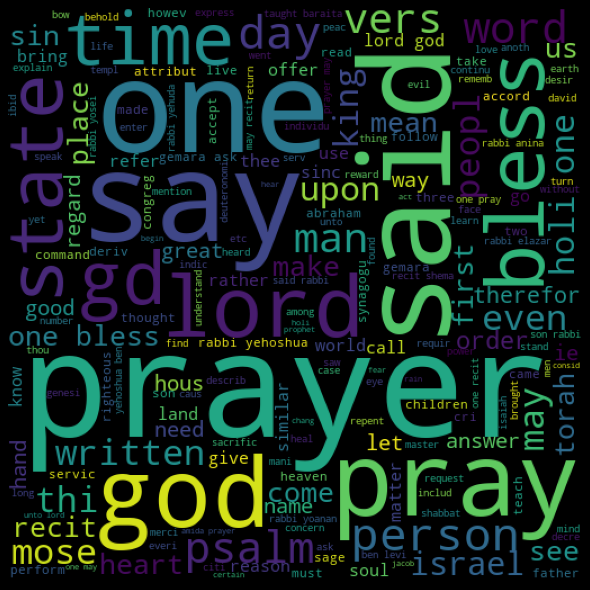

In [532]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

prayer_words = ' '.join(list(all_prayer_df[all_prayer_df['is_prayer'] == 1]['En']))
prayer_wc = WordCloud(width = 512,height = 512).generate(prayer_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(prayer_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

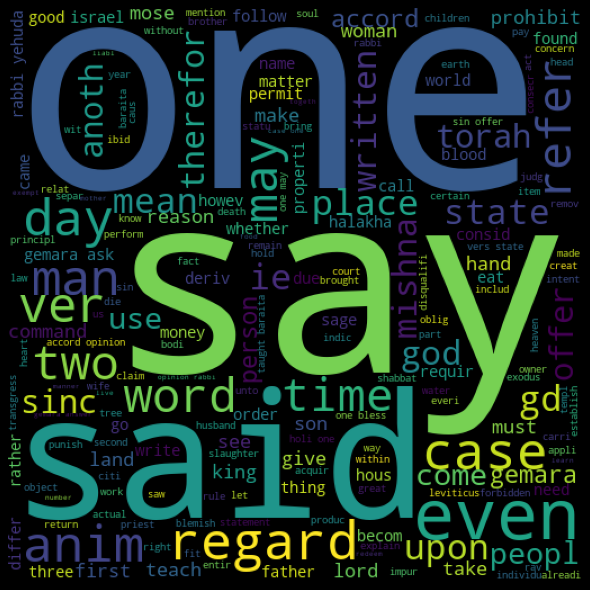

In [533]:
not_prayer_words = ' '.join(list(all_prayer_df[all_prayer_df['is_prayer'] == 0]['En']))
not_prayer_wc = WordCloud(width = 512,height = 512).generate(not_prayer_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(not_prayer_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [534]:
X = all_prayer_df.En
y = all_prayer_df.is_prayer
print(f"Totals: {X.shape} / {y.shape}")

from sklearn.model_selection import train_test_split

# train, test = train_test_split(movies, random_state=42, test_size=0.30, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, test_size=0.20, shuffle=True)

print(f"\nTrain: {X_train.shape} / {y_train.shape}")

print(f"\nTest: {X_test.shape} / {y_test.shape}")

Totals: (1247,) / (1247,)

Train: (997,) / (997,)

Test: (250,) / (250,)


In [0]:
# Convert a collection of text documents to a matrix of token counts

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer(analyzer=process_text)
# vectorizer = CountVectorizer(ngram_range=(2, 4))
# vectorizer = HashingVectorizer(ngram_range=(2, 4),alternate_sign=False)
vectorizer = TfidfVectorizer(
    strip_accents='unicode', 
    analyzer='word', 
    ngram_range=(1,4), 
    norm='l2', 
    max_features = 10000
    )

# vectorizer = TfidfVectorizer(ngram_range=(2, 4))
# vectorizer.fit(X_train)
# vectorizer.get_feature_names()


In [536]:
print("Shape of document term matrix")

# X_train_dtm = vectorizer.transform(X_train)
X_train_dtm = vectorizer.fit_transform(X_train)
print(f"Train: {X_train_dtm.shape}")

# prayer_bag_of_words = vectorizer.fit_transform(all_prayer_df['En'])
X_test_dtm = vectorizer.transform(X_test)
print(f"Test: {X_test_dtm.shape}")


Shape of document term matrix
Train: (997, 10000)
Test: (250, 10000)


In [0]:

# print(vectorizer.get_feature_names())


In [538]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB

classifier = MultinomialNB()
# classifier = ComplementNB()

# for Gaussian need array format
# X_train = X_train.toarray()
# X_test = X_test.toarray()
# classifier = GaussianNB()
# classifier = BernoulliNB()

%time classifier.fit(X_train_dtm, y_train)
y_pred_class = classifier.predict(X_test_dtm)
from sklearn import metrics
print('\nAccuracy:',metrics.accuracy_score(y_test, y_pred_class))
print(f"\nBreakdown:\n{y_test.value_counts()[0]} non-prayer (0), and\n{y_test.value_counts()[1]} prayer (1)")
# print(y_test.value_counts())

null_accuracy = y_test.value_counts().head(1) / len(y_test)
print(f'\nNull accuracy: {null_accuracy[0]}')

negs = y_test.value_counts()[0]
poss = y_test.value_counts()[1]
print('Manual null accuracy:',(1 / (1 + negs/poss)))

print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_class))

CPU times: user 2.2 ms, sys: 0 ns, total: 2.2 ms
Wall time: 2.21 ms

Accuracy: 0.876

Breakdown:
132 non-prayer (0), and
118 prayer (1)

Null accuracy: 0.528
Manual null accuracy: 0.4720000000000001

Confusion Matrix:
[[114  18]
 [ 13 105]]


In [539]:
TP = X_test[y_pred_class + y_test == 2]
TN = X_test[y_pred_class + y_test == 0]
FP = X_test[y_pred_class > y_test]
FN = X_test[y_pred_class < y_test]

pd.options.display.max_colwidth = 100

# pd.style.set_properties(**{'text-align': 'left'})

# print("\n*** TP ***")
# print(TP.sample(5))
# print("\n*** TN ***")
# print(TN.sample(5))
print("\n*** FP ***")
print(FP.sample(10))
print("\n*** FN ***")
print(FN.sample(10))


*** FP ***
1321                                        said voic shout masteri neither voic cri overcom nois sing hear
1749    word refer phenomena mention 6 day creation even though told gd creat univers clear verb refer g...
1895                                                                              ye know power serv father
1795                                                           lord god took man put garden eden dress keep
1071                                  shall know lord god brought forth land egypt may dwell among lord god
1410    kind toler gd display depend need relat first instanc spiritu complet disembodi be inhabit upper...
1899                                 lord said unto noah come thou thi hous ark thee seen righteous generat
1992    10 kingdom hous david establish day fourth day fourth leg support throne happen fourth day lette...
1408    name rav rabbi yehuda said futur holi one bless rejoic righteous let shechinah dwell among every...
1543    furtherm

In [0]:
# FP.to_csv('FP', sep='\t', encoding='utf-8')
# FN.to_csv('FN', sep='\t', encoding='utf-8')
